In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import Huber
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from keras.callbacks import ReduceLROnPlateau
from sklearn.linear_model import LinearRegression

def quantile_loss(i):
  def loss(y_true, y_pred):
    e = y_true - y_pred
    return tf.reduce_mean(tf.maximum(i * e, (i - 1) * e))
  return loss

X = pd.read_csv("Xtable.csv")
y= X.iloc[:,-1].values
X = X.iloc[:,1:].values

window_size = 50;
step_size = 15;

X_win_all = []
y_win_all = []

for i in range(0,len(X)-window_size-15+1,step_size):
  X_win = X[i:i+window_size]
  y_win = y[i+window_size:i+window_size+15]
  X_win_all.append(X_win)
  y_win_all.append(y_win)

X_win_all=np.array(X_win_all)
y_win_all=np.array(y_win_all)

# Although called val, all variables with val is for testing, because we train a model from scratch in every walk
X_trainval = X_win_all[:]
y_trainval = y_win_all[:]

# Walk forward Validation
shift_win = 1

# In a single walk
n_train = 10
n_valid = 1

pred_train_all = []
pred_val_all = []

true_train_all = []
true_val_all = []

rmse_train_per_walk = []
rmse_val_per_walk = []

train_idx_all = []
val_idx_all = []

hist_tr_loss = []

poly_deg = 1

# Coloumns to be normalized
cols_N = np.concatenate([np.arange(8,37),np.array([38,39,41,42,44,45,47,48,50,51,53,54,56,57,58])])

for start_idx in range(0, len(X_trainval)-n_train-n_valid+1, shift_win):

    X_train = X_trainval[start_idx:start_idx+n_train].copy()
    y_train = y_trainval[start_idx:start_idx+n_train].copy()

    X_val = X_trainval[start_idx+n_train:start_idx+n_train+n_valid].copy()
    y_val = y_trainval[start_idx+n_train:start_idx+n_train+n_valid].copy()

    normalizer_y = MinMaxScaler()
    normalizer_X = {}

    for k in cols_N:
        scaler_X = MinMaxScaler()
        X_train[:,:,k] = scaler_X.fit_transform(X_train[:,:,k])
        normalizer_X[k] = scaler_X

    y_train = normalizer_y.fit_transform(y_train.flatten().reshape(-1,1)).reshape(-1,15)

    for k in cols_N:
        X_val[:,:,k] = normalizer_X[k].transform(X_val[:,:,k])

    y_val = normalizer_y.transform(y_val.flatten().reshape(-1,1)).reshape(-1,15)

    n_train_samples = X_train.shape[0]
    n_val_samples = X_val.shape[0]
    n_features = X_train.shape[2]

    X_train_poly = X_train.reshape(n_train_samples, window_size * n_features)
    X_val_poly = X_val.reshape(n_val_samples, window_size * n_features)

    poly = PolynomialFeatures(degree=poly_deg, include_bias=False)
    X_train_poly_exp= poly.fit_transform(X_train_poly)
    X_val_poly_exp = poly.transform(X_val_poly)

    # Model
    model_poly = LinearRegression()
    model_poly.fit(X_train_poly_exp, y_train)

    train_pred = model_poly.predict(X_train_poly_exp)
    val_pred = model_poly.predict(X_val_poly_exp)

    train_pred = normalizer_y.inverse_transform(train_pred)
    val_pred = normalizer_y.inverse_transform(val_pred)

    true_train = normalizer_y.inverse_transform(y_train)
    true_val = normalizer_y.inverse_transform(y_val)

    pred_train_all.append(train_pred)
    pred_val_all.append(val_pred)

    true_train_all.append(true_train)
    true_val_all.append(true_val)

    time_idx = start_idx * step_size + window_size
    train_idx = list(range(time_idx, time_idx + n_train * 15))
    val_idx = list(range(time_idx + n_train * 15, time_idx + (n_train + n_valid) * 15))

    train_idx_all.append(train_idx)
    val_idx_all.append(val_idx)

    rmse_train_per_walk.append(np.sqrt(mean_squared_error(train_pred,true_train)))
    rmse_val_per_walk.append(np.sqrt(mean_squared_error(val_pred,true_val)))


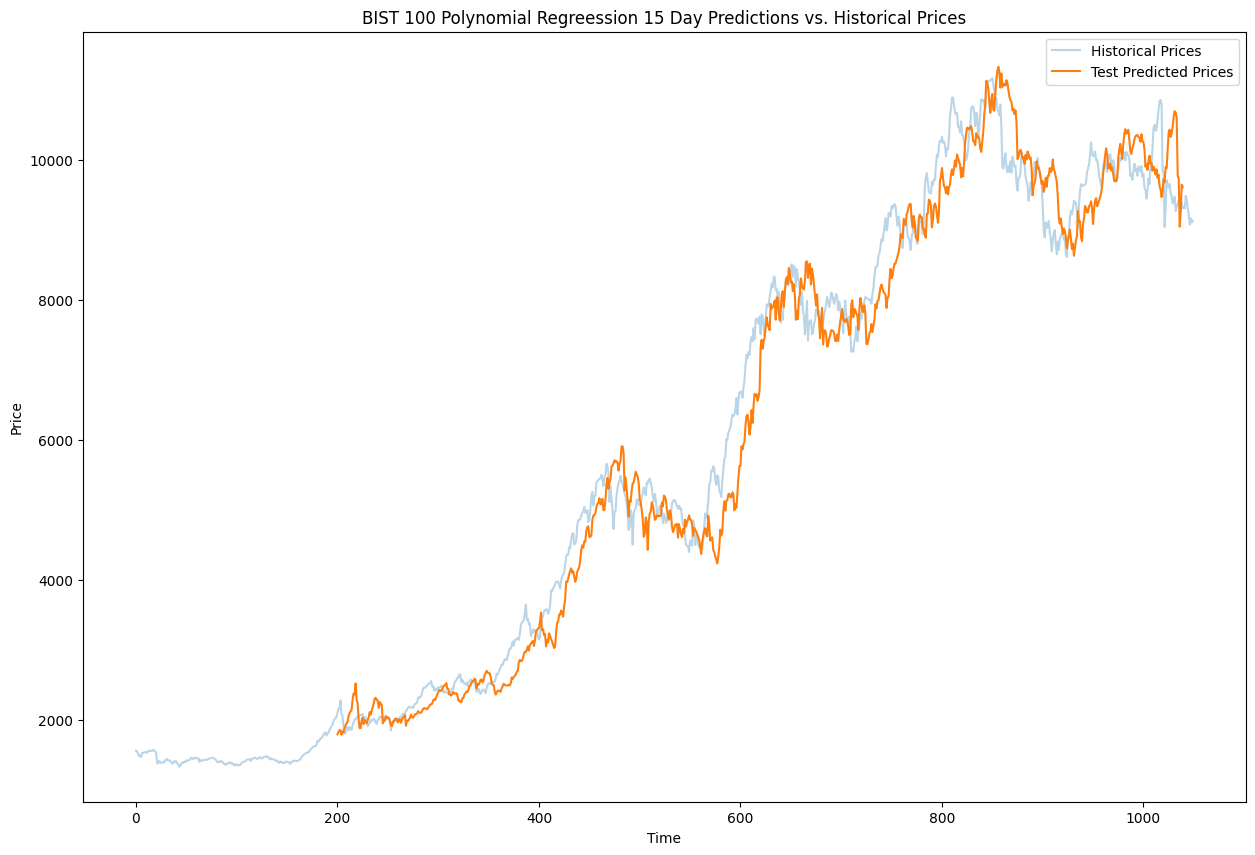

In [2]:
plt.figure(figsize=(15,10))
pred_val_all_flat = np.concatenate([p.flatten() for p in pred_val_all])
true_val_all_flat = np.concatenate([p.flatten() for p in true_val_all])
res = true_val_all_flat.reshape(-1,1) - pred_val_all_flat.reshape(-1,1)

val_idx_all_flat = np.concatenate([p.flatten() for p in np.array(val_idx_all)])

plt.plot(range(len(y)),y, label='Historical Prices', alpha=0.3)
plt.plot(val_idx_all_flat, pred_val_all_flat, label='Test Predicted Prices')

plt.title('BIST 100 Polynomial Regreession 15 Day Predictions vs. Historical Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [5]:
pred_err_val = []
true_err_val = []

for i in range(len(pred_val_all)):
  idx = [idx for idx in val_idx_all[i] if idx < len(y)]
  pred_err_val.extend(pred_val_all[i].flatten()[:len(idx)])
  true_err_val.extend(y[idx])

rmse_val_err = np.sqrt(mean_squared_error(pred_err_val,true_err_val))
r2_val_err = r2_score(pred_err_val,true_err_val)
mae_val_err = mean_absolute_error(pred_err_val,true_err_val)
mape_val_err = mean_absolute_percentage_error(pred_err_val,true_err_val)
acc_val_err = (1-mae_val_err/np.mean(true_err_val))*100

pred_err_train = []
true_err_train = []

for i in range(len(pred_train_all)):
  idx = [idx for idx in train_idx_all[i] if idx < len(y)]
  pred_err_train.extend(pred_train_all[i].flatten()[:len(idx)])
  true_err_train.extend(y[idx])

rmse_train_err = np.sqrt(mean_squared_error(pred_err_train,true_err_train))
r2_train_err = r2_score(pred_err_train,true_err_train)
mae_train_err = mean_absolute_error(pred_err_train,true_err_train)
mape_train_err = mean_absolute_percentage_error(pred_err_train,true_err_train)
acc_train_err = (1-mae_train_err/np.mean(true_err_train))*100

print(f"TRAIN RMSE: {rmse_train_err}")
print(f"TRAIN R2: {r2_train_err}")
print(f"TRAIN MAE: {mae_train_err}")
print(f"TRAIN MAPE: {mape_train_err}")
print(f"TRAIN ACC: {acc_train_err}")

print(f"TEST RMSE: {rmse_val_err}")
print(f"TEST R2: {r2_val_err}")
print(f"TEST MAE: {mae_val_err}")
print(f"TEST MAPE: {mape_val_err}")
print(f"TEST ACC: {acc_val_err}")

TRAIN RMSE: 1.350346150677499e-12
TRAIN R2: 1.0
TRAIN MAE: 8.455864579965627e-13
TRAIN MAPE: 1.6827333529481483e-16
TRAIN ACC: 99.99999999999999
TEST RMSE: 504.4491356266948
TEST R2: 0.9725891521040834
TEST MAE: 395.69739293579914
TEST MAPE: 0.07067451191575563
TEST ACC: 93.96921522957058


In [6]:
pred_val_all_flat = np.concatenate([p.flatten() for p in pred_val_all])
true_val_all_flat = np.concatenate([p.flatten() for p in true_val_all])
res = true_val_all_flat - pred_val_all_flat

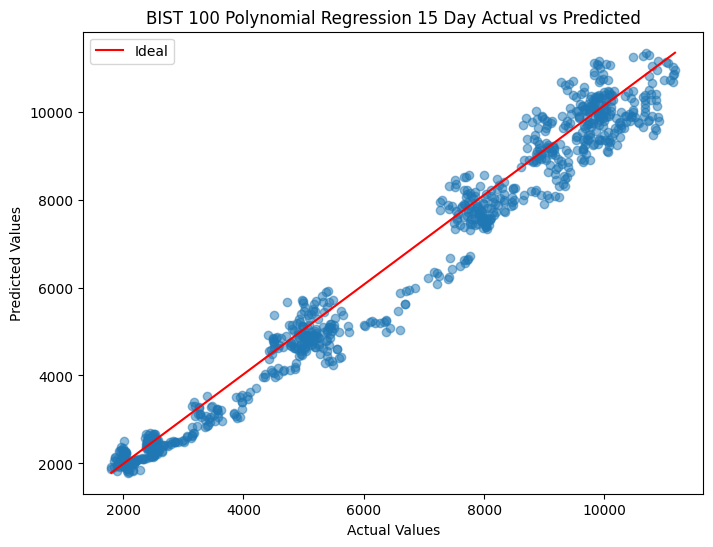

In [7]:
plt.figure(figsize=(8,6))

plt.scatter(true_val_all_flat, pred_val_all_flat, alpha=0.5)
plt.plot([min(true_val_all_flat),max(true_val_all_flat)],[min(pred_val_all_flat),max(pred_val_all_flat)],"r", label="Ideal")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("BIST 100 Polynomial Regression 15 Day Actual vs Predicted")
plt.legend()
plt.show()

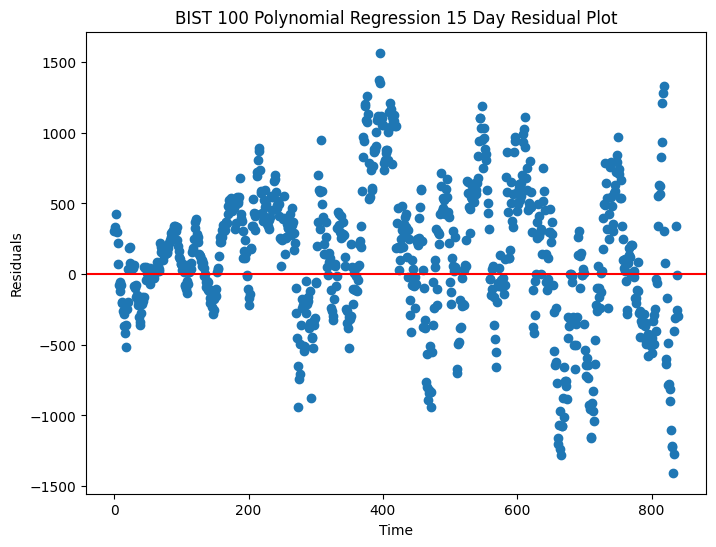

In [8]:
plt.figure(figsize=(8,6))

plt.scatter(range(len(res)),res)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.title("BIST 100 Polynomial Regression 15 Day Residual Plot")
plt.show()
